## Cross-industry standard process for data mining(CRISP-DM)

1.   Business Understanding
2.   Data Understanding
3.   Data Preparation
4.   Modeling
5.   Evaluation
6.  Deployment












In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import lxml
import ast
import json

In [ ]:
#start_date = dt.datetime.today() - relativedelta(years = 2)
#end_date =  dt.datetime.today()

In [ ]:
start_date = dt.datetime(2017,1,1)
end_date =  dt.datetime(2020, 3, 31)

In [ ]:
# dataframe having one row for each date from start date till end date
df_factors = pd.DataFrame({'Business_Date':pd.date_range(start_date, end_date)})
df_factors['Business_Date'] = pd.to_datetime(df_factors['Business_Date'])
df_factors['Business_Date'] = df_factors['Business_Date'].apply(lambda x : x.date())

In [ ]:
#df_factors['Business_Date'] = pd.to_datetime(df_factors['Business_Date'])

In [ ]:
#df_factors['Business_Date'] = df_factors['Business_Date'].apply(lambda x : x.date())

## Stock Volume and Adj Close

In [ ]:
df_temp = data.DataReader('AXISBANK.NS', 'yahoo', df_factors['Business_Date'].min(), df_factors['Business_Date'].max())
df_temp['Business_Date'] = pd.to_datetime(df_temp.index)
df_temp['Business_Date'] = df_temp['Business_Date'].apply(lambda x : x.date())

In [ ]:
#df_temp['Business_Date'] = pd.to_datetime(df_temp.index)

In [ ]:
#df_temp['Business_Date'] = df_temp['Business_Date'].apply(lambda x : x.date())

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 799 entries, 2017-01-02 to 2020-03-31
Data columns (total 7 columns):
High             799 non-null float64
Low              799 non-null float64
Open             799 non-null float64
Close            799 non-null float64
Volume           799 non-null float64
Adj Close        799 non-null float64
Business_Date    799 non-null object
dtypes: float64(6), object(1)
memory usage: 49.9+ KB


In [ ]:
# Stock Data is being merged with the main data frame
df_factors = pd.merge(df_factors,df_temp[['Business_Date','Volume', 'Adj Close']],on='Business_Date', how='left')

## Nifty index data

In [ ]:
df_nifty = data.DataReader('%5ENSEI', 'yahoo', df_factors['Business_Date'].min(), df_factors['Business_Date'].max())
df_nifty['Business_Date'] = pd.to_datetime(df_nifty.index)
df_nifty['Business_Date'] = df_nifty['Business_Date'].apply(lambda x : x.date())

In [ ]:
# Nifty Data is being merged with the main data frame
df_factors = pd.merge(df_factors,df_nifty[['Business_Date', 'Adj Close']],on='Business_Date', how='left',suffixes=('','_nifty'))

In [ ]:
df_factors

Business_Date      Volume   Adj Close  Adj Close_nifty
0       2017-01-01         NaN         NaN              NaN
1       2017-01-02   3054394.0  442.843628      8179.500000
2       2017-01-03   4621782.0  450.261475      8192.250000
3       2017-01-04   3703873.0  448.135010      8190.500000
4       2017-01-05   5829373.0  453.030762      8273.799805
...            ...         ...         ...              ...
1181    2020-03-27  71042591.0  359.750000      8660.250000
1182    2020-03-28         NaN         NaN              NaN
1183    2020-03-29         NaN         NaN              NaN
1184    2020-03-30  61772544.0  368.149994      8281.099609
1185    2020-03-31  34637148.0  379.000000      8597.750000

[1186 rows x 4 columns]

## Nifty Bank index data

In [ ]:
df_banknifty = data.DataReader('%5ENSEBANK', 'yahoo', df_factors['Business_Date'].min(), df_factors['Business_Date'].max())
df_banknifty['Business_Date'] = pd.to_datetime(df_banknifty.index)
df_banknifty['Business_Date'] = df_banknifty['Business_Date'].apply(lambda x : x.date())

In [ ]:
# Nifty Data is being merged with the main data frame
df_factors = pd.merge(df_factors,df_banknifty[['Business_Date', 'Adj Close']],on='Business_Date', how='left',suffixes=('','_banknifty'))

In [ ]:
df_factors

Business_Date      Volume   Adj Close  Adj Close_nifty  \
0       2017-01-01         NaN         NaN              NaN   
1       2017-01-02   3054394.0  442.843628      8179.500000   
2       2017-01-03   4621782.0  450.261475      8192.250000   
3       2017-01-04   3703873.0  448.135010      8190.500000   
4       2017-01-05   5829373.0  453.030762      8273.799805   
...            ...         ...         ...              ...   
1181    2020-03-27  71042591.0  359.750000      8660.250000   
1182    2020-03-28         NaN         NaN              NaN   
1183    2020-03-29         NaN         NaN              NaN   
1184    2020-03-30  61772544.0  368.149994      8281.099609   
1185    2020-03-31  34637148.0  379.000000      8597.750000   

      Adj Close_banknifty  
0                     NaN  
1                     NaN  
2            18035.599609  
3            17891.000000  
4            18115.949219  
...                   ...  
1181         19969.000000  
1182                  NaN  
1183                  NaN  
1184         18782.400391  
1185         19144.000000  

[1186 rows x 5 columns]

## CPI,Money Supply Data,interest rates

In [ ]:
def get_macrodata(indicator, df_input):
    col_head = indicator.lower()
    log = 'log_change_' + col_head 
    percent = 'percent_change_' + col_head
    if indicator.lower() == 'inflation':
        url = "https://sbcharts.investing.com/events_charts/us/973.json"
        attr_id =  '973'
    elif indicator.lower() == 'moneysupply':
        url = "https://sbcharts.investing.com/events_charts/us/756.json"
        attr_id =  '756'
    elif indicator.lower() == 'interestrate':
        url = "https://sbcharts.investing.com/events_charts/us/597.json"
        attr_id =  '597'
    else:
        return
    
       
    urlheader = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }
    payload = {
    'event_attr_ID': attr_id,
    'event_timestamp': dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
    
    req = requests.post(url, headers=urlheader, data=payload)
    soup = BeautifulSoup(req.content, "lxml")
    dict = json.loads(soup.p.contents[0])
    df = pd.DataFrame([i[0],i[1]] for i in dict.get('data') )
    df = df.rename(columns = {0:'Business_Date', 1:col_head})
    df['Business_Date'] =  pd.to_datetime(df['Business_Date'], unit='ms')
    df['Business_Date'] = df['Business_Date'].apply(lambda x : x.date())
    df[log] = np.log(df[col_head]/df[col_head].shift(1))
    df[percent] = (((df[col_head]-df[col_head].shift(1))*100)/df[col_head].shift(1))
    df_input = pd.merge(df_input,df,on='Business_Date', how='left')
    df_input = df_input.sort_values(by = ['Business_Date'], ascending = True)
    
    
    df_input[col_head] = df_input[col_head].fillna(method = 'ffill', limit = 7)
    df_input[log] = df_input[log].fillna(method = 'ffill', limit = 7)
    df_input[percent] = df_input[percent].fillna(method = 'ffill', limit = 7)
    return df_input
    

In [ ]:
# use get_macrodata(indicator, dataframe) function to get inflation data and merge it with input dataframe, pass indicator argument as 'inflation'
# for moneysupply pass indicator as 'moneysupply'
# for interest rate pass indicator as 'interestrate' 
df_factors = get_macrodata('inflation', df_factors)
df_factors = get_macrodata('moneysupply', df_factors)
df_factors = get_macrodata('interestrate', df_factors)


In [ ]:
df_factors.iloc[200:250,:]

Business_Date      Volume   Adj Close  Adj Close_nifty  \
200    2017-07-20  16391849.0  539.330200      9873.299805   
201    2017-07-21   5567645.0  540.129211      9915.250000   
202    2017-07-22         NaN         NaN              NaN   
203    2017-07-23         NaN         NaN              NaN   
204    2017-07-24   4779353.0  534.136658      9966.400391   
205    2017-07-25   8181916.0  544.274048      9964.549805   
206    2017-07-26  12085057.0  528.194031     10020.650391   
207    2017-07-27  12290852.0  523.999268     10020.549805   
208    2017-07-28   8268116.0  514.461060     10014.500000   
209    2017-07-29         NaN         NaN              NaN   
210    2017-07-30         NaN         NaN              NaN   
211    2017-07-31   7245884.0  519.155212     10077.099609   
212    2017-08-01   4562630.0  515.909302     10114.650391   
213    2017-08-02   4079631.0  516.258850     10081.500000   
214    2017-08-03   4140945.0  505.372375     10013.650391   
215    2017-08-04   4972811.0  507.469788     10066.400391   
216    2017-08-05         NaN         NaN              NaN   
217    2017-08-06         NaN         NaN              NaN   
218    2017-08-07   5293884.0  505.172607     10057.400391   
219    2017-08-08   8898560.0  498.830505      9978.549805   
220    2017-08-09   7169705.0  486.346008      9908.049805   
221    2017-08-10  10095387.0  484.897797      9820.250000   
222    2017-08-11   9261420.0  489.092590      9710.799805   
223    2017-08-12         NaN         NaN              NaN   
224    2017-08-13         NaN         NaN              NaN   
225    2017-08-14   3983656.0  491.140045      9794.150391   
226    2017-08-15         NaN         NaN              NaN   
227    2017-08-16   5958229.0  498.880432      9897.299805   
228    2017-08-17   3948664.0  496.533356      9904.150391   
229    2017-08-18   4166976.0  489.791718      9837.400391   
230    2017-08-19         NaN         NaN              NaN   
231    2017-08-20         NaN         NaN              NaN   
232    2017-08-21  17884400.0  494.186249      9754.349609   
233    2017-08-22   6654272.0  498.580811      9765.549805   
234    2017-08-23   3288488.0  502.026520      9852.500000   
235    2017-08-24   7157375.0  506.221313      9857.049805   
236    2017-08-25         NaN         NaN              NaN   
237    2017-08-26         NaN         NaN              NaN   
238    2017-08-27         NaN         NaN              NaN   
239    2017-08-28   3724389.0  509.966675      9912.799805   
240    2017-08-29   3266295.0  502.975342      9796.049805   
241    2017-08-30   3972126.0  503.274963      9884.400391   
242    2017-08-31   4491876.0  499.729401      9917.900391   
243    2017-09-01   4569367.0  506.920441      9974.400391   
244    2017-09-02         NaN         NaN              NaN   
245    2017-09-03         NaN         NaN              NaN   
246    2017-09-04   3744616.0  501.127655      9912.849609   
247    2017-09-05   3216819.0  502.775604      9952.200195   
248    2017-09-06   4947660.0  492.238678      9916.200195   
249    2017-09-07   4564617.0  495.984039      9929.900391   

     Adj Close_banknifty  inflation  log_change_inflation  \
200         24213.349609        NaN                   NaN   
201         24257.050781        NaN                   NaN   
202                  NaN        NaN                   NaN   
203                  NaN        NaN                   NaN   
204         24420.849609        NaN                   NaN   
205         24520.699219        NaN                   NaN   
206         24670.699219        NaN                   NaN   
207         24922.400391        NaN                   NaN   
208         24811.300781        NaN                   NaN   
209                  NaN        NaN                   NaN   
210                  NaN        NaN                   NaN   
211         25103.650391        NaN                   NaN   
212         25122.800781        NaN             

## Gold Rate

In [ ]:
df_gold = data.DataReader('HDFCMFGETF.NS', 'yahoo', df_factors['Business_Date'].min(), df_factors['Business_Date'].max())
df_gold['Business_Date'] = df_gold.index
df_gold['Business_Date'] = df_gold['Business_Date'].apply(lambda x : x.date())

In [ ]:
df_gold

High          Low         Open        Close   Volume  \
Date                                                                      
2017-01-02  2617.000000  2582.100098  2605.500000  2601.500000    626.0   
2017-01-03  2633.949951  2590.199951  2610.000000  2599.050049    736.0   
2017-01-04  2626.850098  2609.000000  2626.000000  2619.500000    311.0   
2017-01-05  2646.399902  2611.000000  2646.399902  2622.649902    465.0   
2017-01-06  2647.399902  2621.000000  2639.350098  2635.000000    257.0   
...                 ...          ...          ...          ...      ...   
2020-03-25  4075.899902  3950.000000  3961.050049  4004.750000   5715.0   
2020-03-26  4050.000000  3830.000000  4050.000000  3931.500000   4532.0   
2020-03-27  4010.000000  3925.000000  3951.449951  4000.649902   3939.0   
2020-03-30  4165.000000  3962.050049  4080.699951  4026.449951  55355.0   
2020-03-31  4187.500000  3946.000000  4187.500000  3953.600098   8263.0   

              Adj Close Business_Date  
Date                                   
2017-01-02  2601.500000    2017-01-02  
2017-01-03  2599.050049    2017-01-03  
2017-01-04  2619.500000    2017-01-04  
2017-01-05  2622.649902    2017-01-05  
2017-01-06  2635.000000    2017-01-06  
...                 ...           ...  
2020-03-25  4004.750000    2020-03-25  
2020-03-26  3931.500000    2020-03-26  
2020-03-27  4000.649902    2020-03-27  
2020-03-30  4026.449951    2020-03-30  
2020-03-31  3953.600098    2020-03-31  

[799 rows x 7 columns]

In [ ]:
# merging gold data into the main dataframe
df_factors = pd.merge(df_factors,df_gold[['Business_Date', 'Adj Close']],on='Business_Date', how='left', suffixes=('','_gold'))

In [ ]:
df_factors

Business_Date      Volume   Adj Close  Adj Close_nifty  \
0       2017-01-01         NaN         NaN              NaN   
1       2017-01-02   3054394.0  442.843628      8179.500000   
2       2017-01-03   4621782.0  450.261475      8192.250000   
3       2017-01-04   3703873.0  448.135010      8190.500000   
4       2017-01-05   5829373.0  453.030762      8273.799805   
...            ...         ...         ...              ...   
1181    2020-03-27  71042591.0  359.750000      8660.250000   
1182    2020-03-28         NaN         NaN              NaN   
1183    2020-03-29         NaN         NaN              NaN   
1184    2020-03-30  61772544.0  368.149994      8281.099609   
1185    2020-03-31  34637148.0  379.000000      8597.750000   

      Adj Close_banknifty  inflation  log_change_inflation  \
0                     NaN        NaN                   NaN   
1                     NaN        NaN                   NaN   
2            18035.599609        NaN                   NaN   
3            17891.000000        NaN                   NaN   
4            18115.949219        NaN                   NaN   
...                   ...        ...                   ...   
1181         19969.000000        NaN                   NaN   
1182                  NaN        NaN                   NaN   
1183                  NaN        NaN                   NaN   
1184         18782.400391        NaN                   NaN   
1185         19144.000000        NaN                   NaN   

      percent_change_inflation  moneysupply  log_change_moneysupply  \
0                          NaN          NaN                     NaN   
1                          NaN          NaN                     NaN   
2                          NaN          NaN                     NaN   
3                          NaN          6.5               -0.088293   
4                          NaN          6.5               -0.088293   
...                        ...          ...                     ...   
1181                       NaN          9.5                0.010582   
1182                       NaN          9.5                0.010582   
1183                       NaN          9.5                0.010582   
1184                       NaN          9.5                0.010582   
1185                       NaN          9.5                0.010582   

      percent_change_moneysupply  interestrate  log_change_interestrate  \
0                            NaN           NaN                      NaN   
1                            NaN           NaN                      NaN   
2                            NaN           NaN                      NaN   
3                      -8.450704           NaN                      NaN   
4                      -8.450704           NaN                      NaN   
...                          ...           ...                      ...   
1181                    1.063830           4.4                -0.157392   
1182                    1.063830           4.4                -0.157392   
1183                    1.063830           4.4                -0.157392   
1184                    1.063830           4.4                -0.157392   
1185                    1.063830           4.4                -0.157392   

      percent_change_interestrate  Adj Close_gold  
0                             NaN             NaN  
1                             NaN     2601.500000  
2                             NaN     2599.050049  
3                             NaN     2619.500000  
4                             NaN     2622.649902  
...                           ...             ...  
1181                   -14.563107     4000.649902  
1182                   -14.563107             NaN  
1183                   -14.563107             NaN  
1184                   -14.563107     4026.449951  
1185                   -14.563107     3953.600098  

[1186 rows x 15 columns]

## Currency Exchange Rate

In [ ]:
df_currency = data.DataReader('INR%3DX', 'yahoo', df_factors['Business_Date'].min() + timedelta(days=1), df_factors['Business_Date'].max() + timedelta(days=1))
df_currency['Business_Date'] = df_currency.index
df_currency['Business_Date'] = df_currency['Business_Date'].apply(lambda x : x.date())

In [ ]:
df_currency

High        Low       Open      Close  Volume  Adj Close  \
Date                                                                        
2017-01-02  68.239998  67.900002  67.944801  67.944801     0.0  67.944801   
2017-01-03  68.430000  68.038002  68.135002  68.133904     0.0  68.133904   
2017-01-04  68.279999  67.934502  68.269997  68.269798     0.0  68.269798   
2017-01-05  67.990501  67.714996  67.885002  67.885498     0.0  67.885498   
2017-01-06  68.101997  67.733498  67.737999  67.733002     0.0  67.733002   
...               ...        ...        ...        ...     ...        ...   
2020-03-26  77.095001  74.769501  77.095001  75.845497     0.0  75.845497   
2020-03-27  76.250000  73.989998  74.725601  74.725601     0.0  74.725601   
2020-03-29  76.379997  74.989998  75.464996  75.464996     0.0  75.464996   
2020-03-30  76.482498  75.134499  75.400101  75.400002     0.0  75.400002   
2020-03-31  77.377602  75.324997  76.110001  75.324997     0.0  75.324997   

           Business_Date  
Date                      
2017-01-02    2017-01-02  
2017-01-03    2017-01-03  
2017-01-04    2017-01-04  
2017-01-05    2017-01-05  
2017-01-06    2017-01-06  
...                  ...  
2020-03-26    2020-03-26  
2020-03-27    2020-03-27  
2020-03-29    2020-03-29  
2020-03-30    2020-03-30  
2020-03-31    2020-03-31  

[845 rows x 7 columns]

In [ ]:
# merging currency data into the main dataframe
df_factors = pd.merge(df_factors,df_currency[['Business_Date', 'Adj Close']],on='Business_Date', how='left', suffixes=('','_currency'))

In [ ]:
df_m = df_factors

In [ ]:
df_m

Business_Date      Volume   Adj Close  Adj Close_nifty  \
0       2017-01-01         NaN         NaN              NaN   
1       2017-01-02   3054394.0  442.843628      8179.500000   
2       2017-01-03   4621782.0  450.261475      8192.250000   
3       2017-01-04   3703873.0  448.135010      8190.500000   
4       2017-01-05   5829373.0  453.030762      8273.799805   
...            ...         ...         ...              ...   
1181    2020-03-27  71042591.0  359.750000      8660.250000   
1182    2020-03-28  71042591.0  359.750000      8660.250000   
1183    2020-03-29  71042591.0  359.750000      8660.250000   
1184    2020-03-30  61772544.0  368.149994      8281.099609   
1185    2020-03-31  34637148.0  379.000000      8597.750000   

      Adj Close_banknifty  inflation  log_change_inflation  \
0                     NaN        NaN                   NaN   
1                     NaN        NaN                   NaN   
2            18035.599609        NaN                   NaN   
3            17891.000000        NaN                   NaN   
4            18115.949219        NaN                   NaN   
...                   ...        ...                   ...   
1181         19969.000000        NaN                   NaN   
1182         19969.000000        NaN                   NaN   
1183         19969.000000        NaN                   NaN   
1184         18782.400391        NaN                   NaN   
1185         19144.000000        NaN                   NaN   

      percent_change_inflation  moneysupply  log_change_moneysupply  \
0                          NaN          NaN                     NaN   
1                          NaN          NaN                     NaN   
2                          NaN          NaN                     NaN   
3                          NaN          6.5               -0.088293   
4                          NaN          6.5               -0.088293   
...                        ...          ...                     ...   
1181                       NaN          9.5                0.010582   
1182                       NaN          9.5                0.010582   
1183                       NaN          9.5                0.010582   
1184                       NaN          9.5                0.010582   
1185                       NaN          9.5                0.010582   

      percent_change_moneysupply  interestrate  log_change_interestrate  \
0                            NaN           NaN                      NaN   
1                            NaN           NaN                      NaN   
2                            NaN           NaN                      NaN   
3                      -8.450704           NaN                      NaN   
4                      -8.450704           NaN                      NaN   
...                          ...           ...                      ...   
1181                    1.063830           4.4                -0.157392   
1182                    1.063830           4.4                -0.157392   
1183                    1.063830           4.4                -0.157392   
1184                    1.063830           4.4                -0.157392   
1185                    1.063830           4.4                -0.157392   

      percent_change_interestrate  Adj Close_gold  Adj Close_currency  
0                             NaN             NaN                 NaN  
1                             NaN     2601.500000           67.944801  
2                             NaN     2599.050049           68.133904  
3                             NaN     2619.500000           68.269798  
4                             NaN     2622.649902           67.885498  
...                           ...             ...                 ...  
1181                   -14.563107     4000.649902           74.725601  
1182                   -14.563107     4000.649902           74.725601  
1183                   -14.563107     4000.649902           75.464996  
1184                   -14.56

In [ ]:
#df_m['Adj Close_currency'] = df_m['Adj Close_currency'].fillna(method = 'ffill')

In [ ]:
df_m['Volume'] = df_m['Volume'].fillna(method = 'ffill')
df_m['Adj Close'] = df_m['Adj Close'].fillna(method = 'ffill')
df_m['Adj Close_nifty'] = df_m['Adj Close_nifty'].fillna(method = 'ffill')
df_m['Adj Close_banknifty'] = df_m['Adj Close_banknifty'].fillna(method = 'ffill')
df_m['Adj Close_gold'] = df_m['Adj Close_gold'].fillna(method = 'ffill')
df_m['Adj Close_currency'] = df_m['Adj Close_currency'].fillna(method = 'ffill')

In [ ]:
df_m

Business_Date      Volume   Adj Close  Adj Close_nifty  \
0       2017-01-01         NaN         NaN              NaN   
1       2017-01-02   3054394.0  442.843628      8179.500000   
2       2017-01-03   4621782.0  450.261475      8192.250000   
3       2017-01-04   3703873.0  448.135010      8190.500000   
4       2017-01-05   5829373.0  453.030762      8273.799805   
...            ...         ...         ...              ...   
1181    2020-03-27  71042591.0  359.750000      8660.250000   
1182    2020-03-28         NaN         NaN              NaN   
1183    2020-03-29         NaN         NaN              NaN   
1184    2020-03-30  61772544.0  368.149994      8281.099609   
1185    2020-03-31  34637148.0  379.000000      8597.750000   

      Adj Close_banknifty  inflation  moneysupply  interestrate  \
0                     NaN        NaN          NaN           NaN   
1                     NaN        NaN          NaN           NaN   
2            18035.599609        NaN          NaN           NaN   
3            17891.000000        NaN          6.5           NaN   
4            18115.949219        NaN          6.5           NaN   
...                   ...        ...          ...           ...   
1181         19969.000000       6.58          9.5           4.4   
1182                  NaN       6.58          9.5           4.4   
1183                  NaN       6.58          9.5           4.4   
1184         18782.400391       6.58          9.5           4.4   
1185         19144.000000       6.58          9.5           4.4   

      Adj Close_gold  Adj Close_currency  
0                NaN                 NaN  
1        2601.500000           67.944801  
2        2599.050049           68.133904  
3        2619.500000           68.269798  
4        2622.649902           67.885498  
...              ...                 ...  
1181     4000.649902           74.725601  
1182             NaN           74.725601  
1183             NaN           75.464996  
1184     4026.449951           75.400002  
1185     3953.600098           75.324997  

[1186 rows x 10 columns]

In [ ]:
df_csv = df_m

In [ ]:
df_csv['log_change_Volume'] = np.log(df_csv['Volume']/df_csv['Volume'].shift(1))
df_csv['percent_change_Volume'] = (((df_csv['Volume']-df_csv['Volume'].shift(1))*100)/df_csv['Volume'].shift(1))

df_csv['log_change_Adj Close'] = np.log(df_csv['Adj Close']/df_csv['Adj Close'].shift(1))
df_csv['percent_change_Adj Close'] = (((df_csv['Adj Close']-df_csv['Adj Close'].shift(1))*100)/df_csv['Adj Close'].shift(1))

df_csv['log_change_Adj Close_nifty'] = np.log(df_csv['Adj Close_nifty']/df_csv['Adj Close_nifty'].shift(1))
df_csv['percent_change_Adj Close_nifty'] = (((df_csv['Adj Close_nifty']-df_csv['Adj Close_nifty'].shift(1))*100)/df_csv['Adj Close_nifty'].shift(1))

df_csv['log_change_Adj Close_banknifty'] = np.log(df_csv['Adj Close_banknifty']/df_csv['Adj Close_banknifty'].shift(1))
df_csv['percent_change_Adj Close_banknifty'] = (((df_csv['Adj Close_banknifty']-df_csv['Adj Close_banknifty'].shift(1))*100)/df_csv['Adj Close_banknifty'].shift(1))

df_csv['log_change_Adj Close_gold'] = np.log(df_csv['Adj Close_gold']/df_csv['Adj Close_gold'].shift(1))
df_csv['percent_change_Adj Close_gold'] = (((df_csv['Adj Close_gold']-df_csv['Adj Close_gold'].shift(1))*100)/df_csv['Adj Close_gold'].shift(1))

df_csv['log_change_Adj Close_currency'] = np.log(df_csv['Adj Close_currency']/df_csv['Adj Close_currency'].shift(1))
df_csv['percent_change_Adj Close_currency'] = (((df_csv['Adj Close_currency']-df_csv['Adj Close_currency'].shift(1))*100)/df_csv['Adj Close_currency'].shift(1))

In [ ]:
df_csv = df_csv.rename(columns = {'Business_Date' : 'date'})

In [ ]:
df_csv.to_csv('d:/features.csv', index=False)

In [ ]:
df_notnan = df_m.dropna()

In [ ]:
df_notnan

Business_Date      Volume   Adj Close  Adj Close_nifty  \
32     2018-08-01   6871812.0  544.473816     11346.200195   
33     2018-08-02   6495837.0  546.571228     11244.700195   
34     2018-08-03  15953749.0  574.037109     11360.799805   
37     2018-08-06  22629303.0  596.059753     11387.099609   
38     2018-08-07  16424825.0  592.314392     11389.450195   
..            ...         ...         ...              ...   
725    2020-06-24  33577082.0  424.649994     10305.299805   
726    2020-06-25  49853200.0  421.700012     10288.900391   
727    2020-06-26  32610915.0  424.850006     10383.000000   
730    2020-06-29  36319455.0  404.799988     10312.400391   
731    2020-06-30  12165160.0  408.799988     10340.849609   

     Adj Close_banknifty  inflation  moneysupply  interestrate  \
32          27596.599609       4.92          9.9           6.5   
33          27355.949219       4.92          9.9           6.5   
34          27695.500000       4.92          9.9           6.5   
37          27898.500000       4.92          9.9           6.5   
38          27875.900391       4.92          9.9           6.5   
..                   ...        ...          ...           ...   
725         21426.800781       5.84         12.4           4.0   
726         21506.150391       5.84         12.4           4.0   
727         21592.050781       5.84         12.4           4.0   
730         21359.000000       5.84         12.4           4.0   
731         21461.800781       5.84         12.4           4.0   

     Adj Close_gold  Adj Close_currency  
32      2722.449951           68.307098  
33      2713.000000           68.615501  
34      2701.100098           68.615501  
37      2710.000000           68.809998  
38      2705.449951           68.596001  
..              ...                 ...  
725     4365.799805           75.970001  
726     4330.049805           75.539803  
727     4348.000000           75.539803  
730     4351.000000           75.619797  
731     4350.500000           75.517998  

[462 rows x 10 columns]

In [ ]:
# dividing present day value with previous day value, log will be applied nect
df_notnan['log_ratio_stock'] = df_notnan['Adj Close']/df_notnan['Adj Close'].shift(1)

df_notnan['log_ratio_nifty'] = df_notnan['Adj Close_nifty']/df_notnan['Adj Close_nifty'].shift(1)

df_notnan['log_ratio_banknifty'] = df_notnan['Adj Close_banknifty']/df_notnan['Adj Close_banknifty'].shift(1)

df_notnan['log_ratio_gold'] = df_notnan['Adj Close_gold']/df_notnan['Adj Close_gold'].shift(1)

df_notnan['log_ratio_currency'] = df_notnan['Adj Close_currency']/df_notnan['Adj Close_currency'].shift(1)


C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df_notnan

Business_Date      Volume   Adj Close  Adj Close_nifty  \
32     2018-08-01   6871812.0  544.473816     11346.200195   
33     2018-08-02   6495837.0  546.571228     11244.700195   
34     2018-08-03  15953749.0  574.037109     11360.799805   
37     2018-08-06  22629303.0  596.059753     11387.099609   
38     2018-08-07  16424825.0  592.314392     11389.450195   
..            ...         ...         ...              ...   
725    2020-06-24  33577082.0  424.649994     10305.299805   
726    2020-06-25  49853200.0  421.700012     10288.900391   
727    2020-06-26  32610915.0  424.850006     10383.000000   
730    2020-06-29  36319455.0  404.799988     10312.400391   
731    2020-06-30  12165160.0  408.799988     10340.849609   

     Adj Close_banknifty  inflation  moneysupply  interestrate  \
32          27596.599609       4.92          9.9           6.5   
33          27355.949219       4.92          9.9           6.5   
34          27695.500000       4.92          9.9           6.5   
37          27898.500000       4.92          9.9           6.5   
38          27875.900391       4.92          9.9           6.5   
..                   ...        ...          ...           ...   
725         21426.800781       5.84         12.4           4.0   
726         21506.150391       5.84         12.4           4.0   
727         21592.050781       5.84         12.4           4.0   
730         21359.000000       5.84         12.4           4.0   
731         21461.800781       5.84         12.4           4.0   

     Adj Close_gold  Adj Close_currency  log_ratio_stock  log_ratio_nifty  \
32      2722.449951           68.307098              NaN              NaN   
33      2713.000000           68.615501         1.003852         0.991054   
34      2701.100098           68.615501         1.050251         1.010325   
37      2710.000000           68.809998         1.038364         1.002315   
38      2705.449951           68.596001         0.993716         1.000206   
..              ...                 ...              ...              ...   
725     4365.799805           75.970001         0.957173         0.984175   
726     4330.049805           75.539803         0.993053         0.998409   
727     4348.000000           75.539803         1.007470         1.009146   
730     4351.000000           75.619797         0.952807         0.993200   
731     4350.500000           75.517998         1.009881         1.002759   

     log_ratio_banknifty  log_ratio_gold  log_ratio_currency  
32                   NaN             NaN                 NaN  
33              0.991280        0.996529            1.004515  
34              1.012412        0.995614            1.000000  
37              1.007330        1.003295            1.002835  
38              0.999190        0.998321            0.996890  
..                   ...             ...                 ...  
725             0.962358        1.010239            1.004790  
726             1.003703        0.991811            0.994337  
727             1.003994        1.004145            1.000000  
730             0.989207        1.000690            1.001059  
731             1.004813        0.999885            0.998654  

[462 rows x 15 columns]

In [ ]:
df_notnan['log_ratio_stock'] = df_notnan['log_ratio_stock'].apply(lambda x : np.log(x))
df_notnan['log_ratio_nifty'] = df_notnan['log_ratio_nifty'].apply(lambda x : np.log(x))
df_notnan['log_ratio_banknifty'] = df_notnan['log_ratio_banknifty'].apply(lambda x : np.log(x))
df_notnan['log_ratio_gold'] = df_notnan['log_ratio_gold'].apply(lambda x : np.log(x))
df_notnan['log_ratio_currency'] = df_notnan['log_ratio_currency'].apply(lambda x : np.log(x))

C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
df_notnan

Business_Date      Volume   Adj Close  Adj Close_nifty  \
32     2018-08-01   6871812.0  544.473816     11346.200195   
33     2018-08-02   6495837.0  546.571228     11244.700195   
34     2018-08-03  15953749.0  574.037109     11360.799805   
37     2018-08-06  22629303.0  596.059753     11387.099609   
38     2018-08-07  16424825.0  592.314392     11389.450195   
..            ...         ...         ...              ...   
725    2020-06-24  33577082.0  424.649994     10305.299805   
726    2020-06-25  49853200.0  421.700012     10288.900391   
727    2020-06-26  32610915.0  424.850006     10383.000000   
730    2020-06-29  36319455.0  404.799988     10312.400391   
731    2020-06-30  12165160.0  408.799988     10340.849609   

     Adj Close_banknifty  inflation  moneysupply  interestrate  \
32          27596.599609       4.92          9.9           6.5   
33          27355.949219       4.92          9.9           6.5   
34          27695.500000       4.92          9.9           6.5   
37          27898.500000       4.92          9.9           6.5   
38          27875.900391       4.92          9.9           6.5   
..                   ...        ...          ...           ...   
725         21426.800781       5.84         12.4           4.0   
726         21506.150391       5.84         12.4           4.0   
727         21592.050781       5.84         12.4           4.0   
730         21359.000000       5.84         12.4           4.0   
731         21461.800781       5.84         12.4           4.0   

     Adj Close_gold  Adj Close_currency  log_ratio_stock  log_ratio_nifty  \
32      2722.449951           68.307098              NaN              NaN   
33      2713.000000           68.615501         0.003845        -0.008986   
34      2701.100098           68.615501         0.049029         0.010272   
37      2710.000000           68.809998         0.037647         0.002312   
38      2705.449951           68.596001        -0.006303         0.000206   
..              ...                 ...              ...              ...   
725     4365.799805           75.970001        -0.043771        -0.015951   
726     4330.049805           75.539803        -0.006971        -0.001593   
727     4348.000000           75.539803         0.007442         0.009104   
730     4351.000000           75.619797        -0.048343        -0.006823   
731     4350.500000           75.517998         0.009833         0.002755   

     log_ratio_banknifty  log_ratio_gold  log_ratio_currency  
32                   NaN             NaN                 NaN  
33             -0.008759       -0.003477            0.004505  
34              0.012336       -0.004396            0.000000  
37              0.007303        0.003290            0.002831  
38             -0.000810       -0.001680           -0.003115  
..                   ...             ...                 ...  
725            -0.038369        0.010187            0.004779  
726             0.003696       -0.008222           -0.005679  
727             0.003986        0.004137            0.000000  
730            -0.010852        0.000690            0.001058  
731             0.004801       -0.000115           -0.001347  

[462 rows x 15 columns]

In [ ]:
# Adding a column for adjusted close price of the stock for next day (t+1 day) to compare with other features value at current day (t day)
# This is being because for the day we want to stock price we will only have data for the previous day.
df_notnan['lognextdaystockinc'] = df_notnan['Adj Close'].shift(-1)/df_notnan['Adj Close']

df_notnan['lognextdaystockinc'] = df_notnan['lognextdaystockinc'].apply(lambda x : np.log(x))

C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df_notnan['nextdaystockprice'] = df_notnan['Adj Close'].shift(-1)

C:\Users\abhis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_notnan = df_notnan.ffill()

In [ ]:
df_notnan

Business_Date      Volume   Adj Close  Adj Close_nifty  \
32     2018-08-01   6871812.0  544.473816     11346.200195   
33     2018-08-02   6495837.0  546.571228     11244.700195   
34     2018-08-03  15953749.0  574.037109     11360.799805   
37     2018-08-06  22629303.0  596.059753     11387.099609   
38     2018-08-07  16424825.0  592.314392     11389.450195   
..            ...         ...         ...              ...   
725    2020-06-24  33577082.0  424.649994     10305.299805   
726    2020-06-25  49853200.0  421.700012     10288.900391   
727    2020-06-26  32610915.0  424.850006     10383.000000   
730    2020-06-29  36319455.0  404.799988     10312.400391   
731    2020-06-30  12165160.0  408.799988     10340.849609   

     Adj Close_banknifty  inflation  moneysupply  interestrate  \
32          27596.599609       4.92          9.9           6.5   
33          27355.949219       4.92          9.9           6.5   
34          27695.500000       4.92          9.9           6.5   
37          27898.500000       4.92          9.9           6.5   
38          27875.900391       4.92          9.9           6.5   
..                   ...        ...          ...           ...   
725         21426.800781       5.84         12.4           4.0   
726         21506.150391       5.84         12.4           4.0   
727         21592.050781       5.84         12.4           4.0   
730         21359.000000       5.84         12.4           4.0   
731         21461.800781       5.84         12.4           4.0   

     Adj Close_gold  Adj Close_currency  log_ratio_stock  log_ratio_nifty  \
32      2722.449951           68.307098              NaN              NaN   
33      2713.000000           68.615501         0.003845        -0.008986   
34      2701.100098           68.615501         0.049029         0.010272   
37      2710.000000           68.809998         0.037647         0.002312   
38      2705.449951           68.596001        -0.006303         0.000206   
..              ...                 ...              ...              ...   
725     4365.799805           75.970001        -0.043771        -0.015951   
726     4330.049805           75.539803        -0.006971        -0.001593   
727     4348.000000           75.539803         0.007442         0.009104   
730     4351.000000           75.619797        -0.048343        -0.006823   
731     4350.500000           75.517998         0.009833         0.002755   

     log_ratio_banknifty  log_ratio_gold  log_ratio_currency  \
32                   NaN             NaN                 NaN   
33             -0.008759       -0.003477            0.004505   
34              0.012336       -0.004396            0.000000   
37              0.007303        0.003290            0.002831   
38             -0.000810       -0.001680           -0.003115   
..                   ...             ...                 ...   
725            -0.038369        0.010187            0.004779   
726             0.003696       -0.008222           -0.005679   
727             0.003986        0.004137            0.000000   
730            -0.010852        0.000690            0.001058   
731             0.004801       -0.000115           -0.001347   

     lognextdaystockinc  nextdaystockprice  
32             0.003845         546.571228  
33             0.049029         574.037109  
34             0.037647         596.059753  
37            -0.006303         592.314392  
38             0.005465         595.560364  
..                  ...                ...  
725           -0.006971         421.700012  
726            0.007442         424.850006  
727           -0.048343         404.799988  
730            0.009833         408.799988  
731            0.009833         408.799988  

[462 rows x 17 columns]

In [ ]:
df_absolute = df_notnan[['Business_Date', 'Volume', 'Adj Close', 'Adj Close_nifty', 'Adj Close_banknifty', 'inflation', 'moneysupply', 'interestrate','Adj Close_gold','Adj Close_currency','nextdaystockprice']].copy()

In [ ]:
df_logval = df_notnan[['Business_Date','log_ratio_stock', 'log_ratio_nifty','log_ratio_banknifty', 'log_ratio_gold','log_ratio_currency', 'lognextdaystockinc'  ]].copy()

In [ ]:
df_logval

Business_Date  log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
32     2018-08-01              NaN              NaN                  NaN   
33     2018-08-02         0.003845        -0.008986            -0.008759   
34     2018-08-03         0.049029         0.010272             0.012336   
37     2018-08-06         0.037647         0.002312             0.007303   
38     2018-08-07        -0.006303         0.000206            -0.000810   
..            ...              ...              ...                  ...   
725    2020-06-24        -0.043771        -0.015951            -0.038369   
726    2020-06-25        -0.006971        -0.001593             0.003696   
727    2020-06-26         0.007442         0.009104             0.003986   
730    2020-06-29        -0.048343        -0.006823            -0.010852   
731    2020-06-30         0.009833         0.002755             0.004801   

     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
32              NaN                 NaN            0.003845  
33        -0.003477            0.004505            0.049029  
34        -0.004396            0.000000            0.037647  
37         0.003290            0.002831           -0.006303  
38        -0.001680           -0.003115            0.005465  
..              ...                 ...                 ...  
725        0.010187            0.004779           -0.006971  
726       -0.008222           -0.005679            0.007442  
727        0.004137            0.000000           -0.048343  
730        0.000690            0.001058            0.009833  
731       -0.000115           -0.001347            0.009833  

[462 rows x 7 columns]

## Correlation among absolute values

### Pearson Correlation

In [ ]:
df_absolute.iloc[-5:,1:].corr(method='pearson')

Volume  Adj Close  Adj Close_nifty  \
Volume               1.000000   0.412489        -0.508012   
Adj Close            0.412489   1.000000         0.113607   
Adj Close_nifty     -0.508012   0.113607         1.000000   
Adj Close_banknifty  0.071877   0.671687         0.612539   
inflation                 NaN        NaN              NaN   
moneysupply               NaN        NaN              NaN   
interestrate              NaN        NaN              NaN   
Adj Close_gold      -0.485356  -0.010546         0.155887   
Adj Close_currency   0.098886   0.349618        -0.369218   
nextdaystockprice    0.587476   0.427441        -0.832598   

                     Adj Close_banknifty  inflation  moneysupply  \
Volume                          0.071877        NaN          NaN   
Adj Close                       0.671687        NaN          NaN   
Adj Close_nifty                 0.612539        NaN          NaN   
Adj Close_banknifty             1.000000        NaN          NaN   
inflation                            NaN        NaN          NaN   
moneysupply                          NaN        NaN          NaN   
interestrate                         NaN        NaN          NaN   
Adj Close_gold                 -0.397557        NaN          NaN   
Adj Close_currency             -0.405489        NaN          NaN   
nextdaystockprice              -0.143337        NaN          NaN   

                     interestrate  Adj Close_gold  Adj Close_currency  \
Volume                        NaN       -0.485356            0.098886   
Adj Close                     NaN       -0.010546            0.349618   
Adj Close_nifty               NaN        0.155887           -0.369218   
Adj Close_banknifty           NaN       -0.397557           -0.405489   
inflation                     NaN             NaN                 NaN   
moneysupply                   NaN             NaN                 NaN   
interestrate                  NaN             NaN                 NaN   
Adj Close_gold                NaN        1.000000            0.756853   
Adj Close_currency            NaN        0.756853            1.000000   
nextdaystockprice             NaN       -0.188295            0.461380   

                     nextdaystockprice  
Volume                        0.587476  
Adj Close                     0.427441  
Adj Close_nifty              -0.832598  
Adj Close_banknifty          -0.143337  
inflation                          NaN  
moneysupply                        NaN  
interestrate                       NaN  
Adj Close_gold               -0.188295  
Adj Close_currency            0.461380  
nextdaystockprice             1.000000

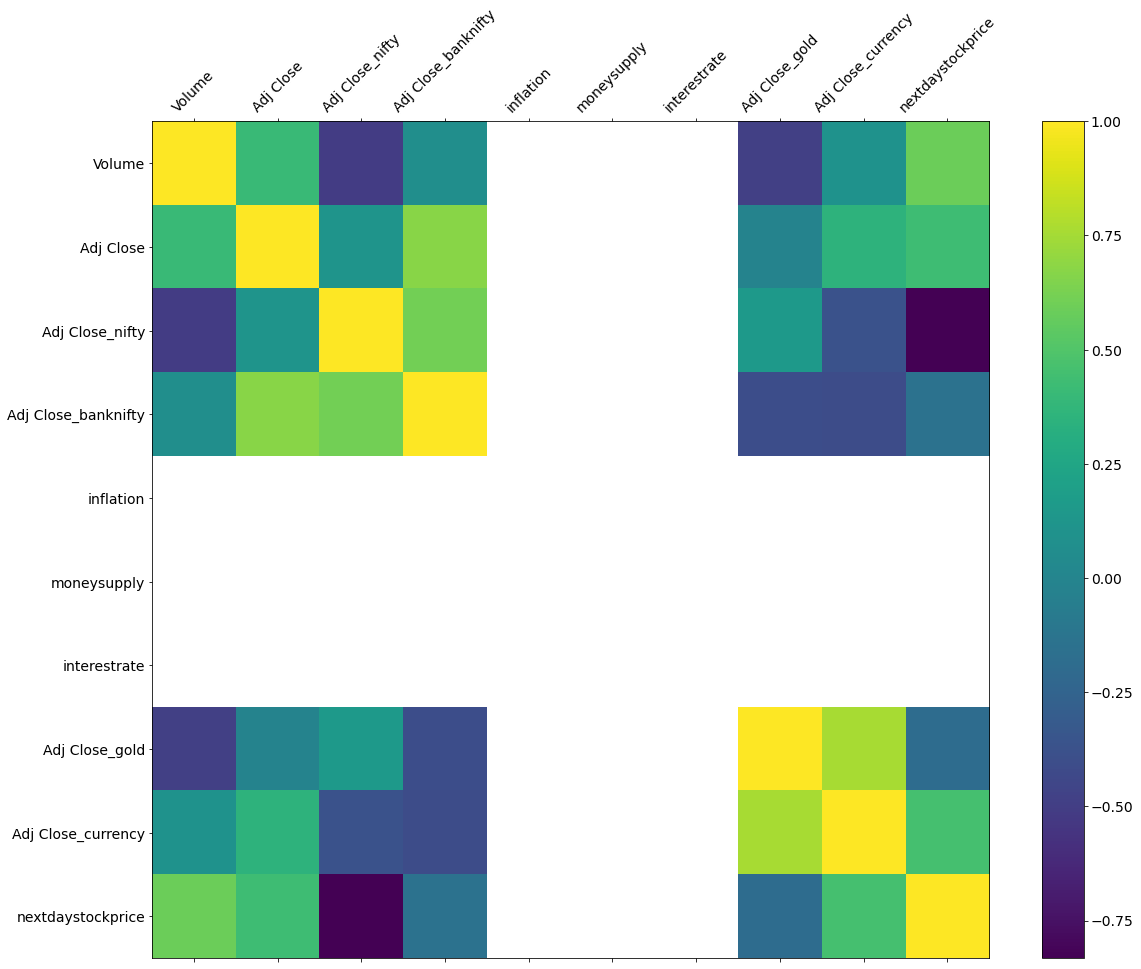

In [ ]:
# Person correlation for last 5 rows for every feature
f = plt.figure(figsize=(19, 15))
plt.matshow(df_absolute.iloc[-5:,1:].corr(), fignum=f.number)
plt.xticks(range(df_absolute.iloc[-5:,1:].shape[1]), df_absolute.iloc[-5:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_absolute.iloc[-5:,1:].shape[1]), df_absolute.iloc[-5:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


In [ ]:
# correlation for last 5 rows (excluding the last row)
df_absolute.iloc[-6:-1,1:].corr(method='pearson')

Volume  Adj Close  Adj Close_nifty  \
Volume               1.000000  -0.343505        -0.648675   
Adj Close           -0.343505   1.000000         0.776807   
Adj Close_nifty     -0.648675   0.776807         1.000000   
Adj Close_banknifty -0.402382   0.882362         0.926550   
inflation                 NaN        NaN              NaN   
moneysupply               NaN        NaN              NaN   
interestrate              NaN        NaN              NaN   
Adj Close_gold      -0.255052  -0.542385        -0.557294   
Adj Close_currency  -0.314681   0.012142        -0.280351   
nextdaystockprice    0.331256   0.540707         0.049647   

                     Adj Close_banknifty  inflation  moneysupply  \
Volume                         -0.402382        NaN          NaN   
Adj Close                       0.882362        NaN          NaN   
Adj Close_nifty                 0.926550        NaN          NaN   
Adj Close_banknifty             1.000000        NaN          NaN   
inflation                            NaN        NaN          NaN   
moneysupply                          NaN        NaN          NaN   
interestrate                         NaN        NaN          NaN   
Adj Close_gold                 -0.739265        NaN          NaN   
Adj Close_currency             -0.250312        NaN          NaN   
nextdaystockprice               0.405689        NaN          NaN   

                     interestrate  Adj Close_gold  Adj Close_currency  \
Volume                        NaN       -0.255052           -0.314681   
Adj Close                     NaN       -0.542385            0.012142   
Adj Close_nifty               NaN       -0.557294           -0.280351   
Adj Close_banknifty           NaN       -0.739265           -0.250312   
inflation                     NaN             NaN                 NaN   
moneysupply                   NaN             NaN                 NaN   
interestrate                  NaN             NaN                 NaN   
Adj Close_gold                NaN        1.000000            0.698424   
Adj Close_currency            NaN        0.698424            1.000000   
nextdaystockprice             NaN       -0.428422            0.280585   

                     nextdaystockprice  
Volume                        0.331256  
Adj Close                     0.540707  
Adj Close_nifty               0.049647  
Adj Close_banknifty           0.405689  
inflation                          NaN  
moneysupply                        NaN  
interestrate                       NaN  
Adj Close_gold               -0.428422  
Adj Close_currency            0.280585  
nextdaystockprice             1.000000

In [ ]:
# Pearson correlation for whole dataset
df_absolute.corr(method='pearson')

Volume  Adj Close  Adj Close_nifty  \
Volume               1.000000  -0.780045        -0.704603   
Adj Close           -0.780045   1.000000         0.899596   
Adj Close_nifty     -0.704603   0.899596         1.000000   
Adj Close_banknifty -0.764571   0.962348         0.958562   
inflation            0.405733  -0.405290        -0.180319   
moneysupply          0.212323  -0.143869        -0.001520   
interestrate        -0.595479   0.453410         0.301797   
Adj Close_gold       0.649574  -0.579125        -0.453359   
Adj Close_currency   0.726219  -0.859588        -0.777361   
nextdaystockprice   -0.774060   0.992275         0.896535   

                     Adj Close_banknifty  inflation  moneysupply  \
Volume                         -0.764571   0.405733     0.212323   
Adj Close                       0.962348  -0.405290    -0.143869   
Adj Close_nifty                 0.958562  -0.180319    -0.001520   
Adj Close_banknifty             1.000000  -0.254709    -0.147051   
inflation                      -0.254709   1.000000    -0.099293   
moneysupply                    -0.147051  -0.099293     1.000000   
interestrate                    0.376018  -0.691561    -0.240624   
Adj Close_gold                 -0.514943   0.730741     0.177108   
Adj Close_currency             -0.839623   0.544772     0.065624   
nextdaystockprice               0.956765  -0.416072    -0.136390   

                     interestrate  Adj Close_gold  Adj Close_currency  \
Volume                  -0.595479        0.649574            0.726219   
Adj Close                0.453410       -0.579125           -0.859588   
Adj Close_nifty          0.301797       -0.453359           -0.777361   
Adj Close_banknifty      0.376018       -0.514943           -0.839623   
inflation               -0.691561        0.730741            0.544772   
moneysupply             -0.240624        0.177108            0.065624   
interestrate             1.000000       -0.955568           -0.605632   
Adj Close_gold          -0.955568        1.000000            0.731921   
Adj Close_currency      -0.605632        0.731921            1.000000   
nextdaystockprice        0.457292       -0.584066           -0.860592   

                     nextdaystockprice  
Volume                       -0.774060  
Adj Close                     0.992275  
Adj Close_nifty               0.896535  
Adj Close_banknifty           0.956765  
inflation                    -0.416072  
moneysupply                  -0.136390  
interestrate                  0.457292  
Adj Close_gold               -0.584066  
Adj Close_currency           -0.860592  
nextdaystockprice             1.000000

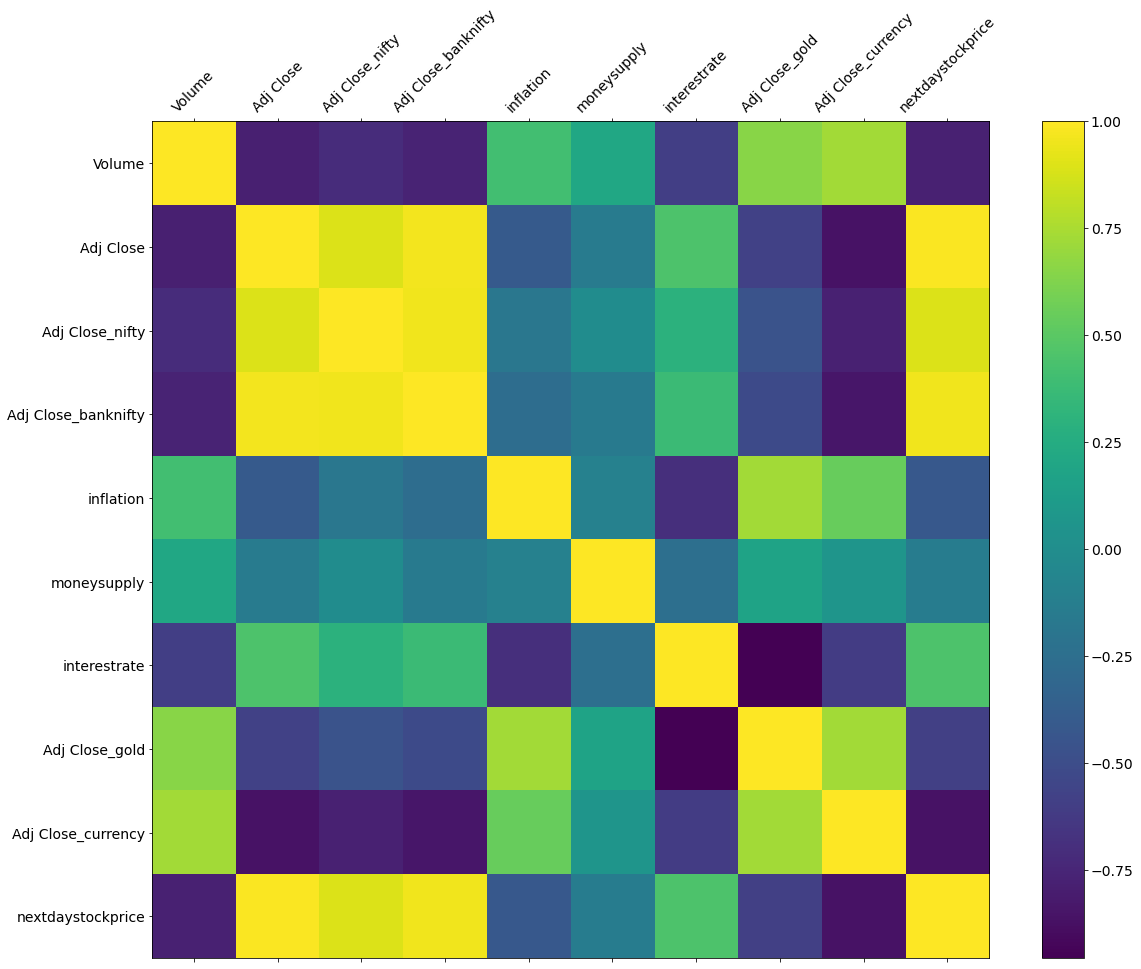

In [ ]:
# Person correlation between all features for all rows
f = plt.figure(figsize=(19, 15))
plt.matshow(df_absolute.iloc[:,1:].corr(), fignum=f.number)
plt.xticks(range(df_absolute.iloc[:,1:].shape[1]), df_absolute.iloc[:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_absolute.iloc[:,1:].shape[1]), df_absolute.iloc[:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


### Spearman Correlation

In [ ]:
# Spearman Correlation for latest 5 datapoints
df_absolute.iloc[-5:,1:].corr(method='spearman')

Volume  Adj Close  Adj Close_nifty  \
Volume               1.000000  -0.200000        -0.800000   
Adj Close           -0.200000   1.000000         0.200000   
Adj Close_nifty     -0.800000   0.200000         1.000000   
Adj Close_banknifty -0.200000   0.700000         0.300000   
inflation                 NaN        NaN              NaN   
moneysupply               NaN        NaN              NaN   
interestrate              NaN        NaN              NaN   
Adj Close_gold      -0.200000  -0.200000         0.000000   
Adj Close_currency   0.461690   0.102598        -0.410391   
nextdaystockprice    0.666886  -0.153897        -0.974679   

                     Adj Close_banknifty  inflation  moneysupply  \
Volume                         -0.200000        NaN          NaN   
Adj Close                       0.700000        NaN          NaN   
Adj Close_nifty                 0.300000        NaN          NaN   
Adj Close_banknifty             1.000000        NaN          NaN   
inflation                            NaN        NaN          NaN   
moneysupply                          NaN        NaN          NaN   
interestrate                         NaN        NaN          NaN   
Adj Close_gold                 -0.800000        NaN          NaN   
Adj Close_currency             -0.564288        NaN          NaN   
nextdaystockprice              -0.205196        NaN          NaN   

                     interestrate  Adj Close_gold  Adj Close_currency  \
Volume                        NaN       -0.200000            0.461690   
Adj Close                     NaN       -0.200000            0.102598   
Adj Close_nifty               NaN        0.000000           -0.410391   
Adj Close_banknifty           NaN       -0.800000           -0.564288   
inflation                     NaN             NaN                 NaN   
moneysupply                   NaN             NaN                 NaN   
interestrate                  NaN             NaN                 NaN   
Adj Close_gold                NaN        1.000000            0.666886   
Adj Close_currency            NaN        0.666886            1.000000   
nextdaystockprice             NaN       -0.051299            0.263158   

                     nextdaystockprice  
Volume                        0.666886  
Adj Close                    -0.153897  
Adj Close_nifty              -0.974679  
Adj Close_banknifty          -0.205196  
inflation                          NaN  
moneysupply                        NaN  
interestrate                       NaN  
Adj Close_gold               -0.051299  
Adj Close_currency            0.263158  
nextdaystockprice             1.000000

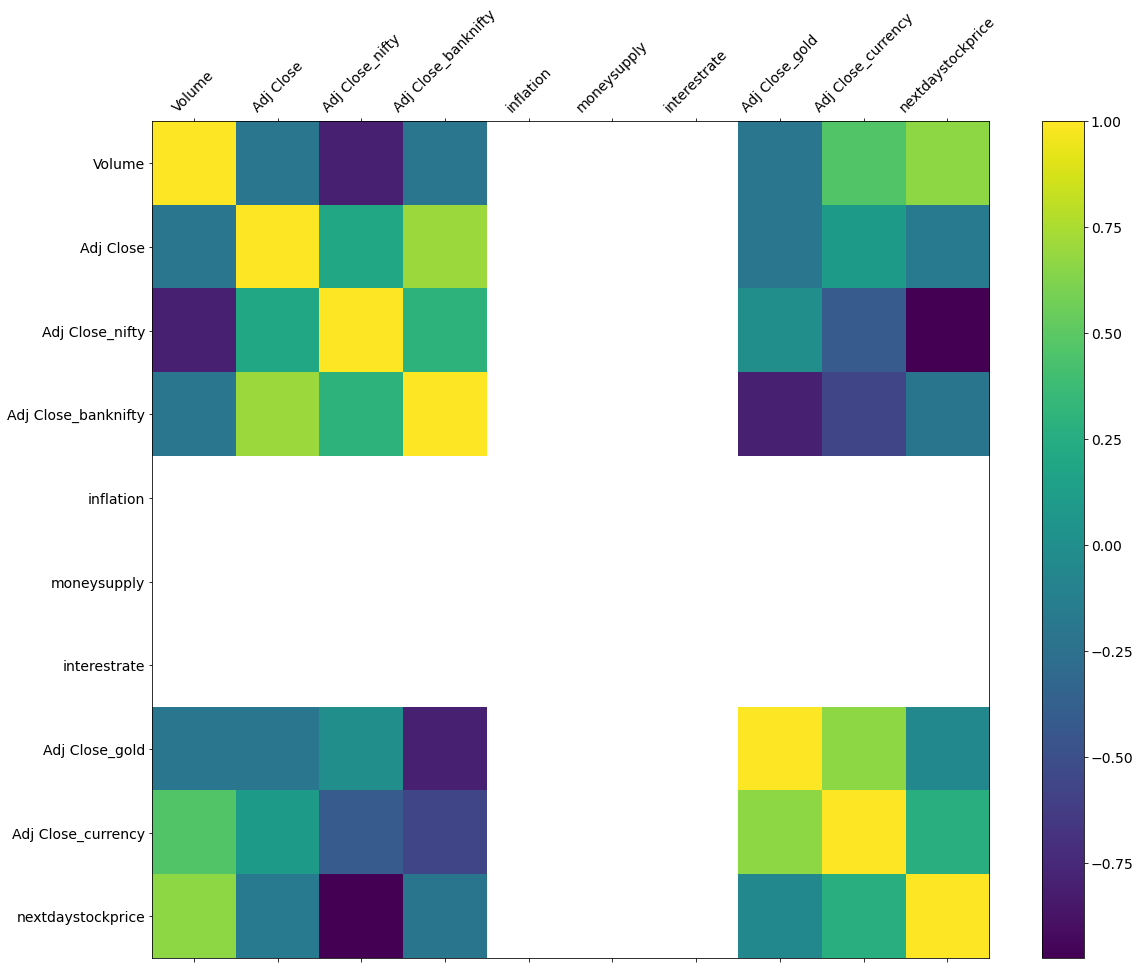

In [ ]:
# Spearman correlation for latest 5 datapoints for every feature
f = plt.figure(figsize=(19, 15))
plt.matshow(df_absolute.iloc[-5:,1:].corr(method='spearman'), fignum=f.number)
plt.xticks(range(df_absolute.iloc[-5:,1:].shape[1]), df_absolute.iloc[-5:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_absolute.iloc[-5:,1:].shape[1]), df_absolute.iloc[-5:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
# spearman correlation for whole dataset
df_absolute.corr(method='spearman')

Volume  Adj Close  Adj Close_nifty  \
Volume               1.000000  -0.600486        -0.539140   
Adj Close           -0.600486   1.000000         0.850093   
Adj Close_nifty     -0.539140   0.850093         1.000000   
Adj Close_banknifty -0.563980   0.905909         0.964098   
inflation            0.364084  -0.363903        -0.013359   
moneysupply         -0.054413   0.119377        -0.024053   
interestrate        -0.294520   0.056702        -0.028190   
Adj Close_gold       0.323916  -0.161739        -0.126671   
Adj Close_currency   0.510250  -0.706101        -0.581264   
nextdaystockprice   -0.606226   0.985350         0.840854   

                     Adj Close_banknifty  inflation  moneysupply  \
Volume                         -0.563980   0.364084    -0.054413   
Adj Close                       0.905909  -0.363903     0.119377   
Adj Close_nifty                 0.964098  -0.013359    -0.024053   
Adj Close_banknifty             1.000000  -0.095716    -0.011661   
inflation                      -0.095716   1.000000    -0.349988   
moneysupply                    -0.011661  -0.349988     1.000000   
interestrate                   -0.055675  -0.652207    -0.034112   
Adj Close_gold                 -0.076931   0.606623     0.016670   
Adj Close_currency             -0.637410   0.565037    -0.148545   
nextdaystockprice               0.896683  -0.374843     0.121893   

                     interestrate  Adj Close_gold  Adj Close_currency  \
Volume                  -0.294520        0.323916            0.510250   
Adj Close                0.056702       -0.161739           -0.706101   
Adj Close_nifty         -0.028190       -0.126671           -0.581264   
Adj Close_banknifty     -0.055675       -0.076931           -0.637410   
inflation               -0.652207        0.606623            0.565037   
moneysupply             -0.034112        0.016670           -0.148545   
interestrate             1.000000       -0.932513           -0.419329   
Adj Close_gold          -0.932513        1.000000            0.524261   
Adj Close_currency      -0.419329        0.524261            1.000000   
nextdaystockprice        0.063650       -0.168492           -0.704421   

                     nextdaystockprice  
Volume                       -0.606226  
Adj Close                     0.985350  
Adj Close_nifty               0.840854  
Adj Close_banknifty           0.896683  
inflation                    -0.374843  
moneysupply                   0.121893  
interestrate                  0.063650  
Adj Close_gold               -0.168492  
Adj Close_currency           -0.704421  
nextdaystockprice             1.000000

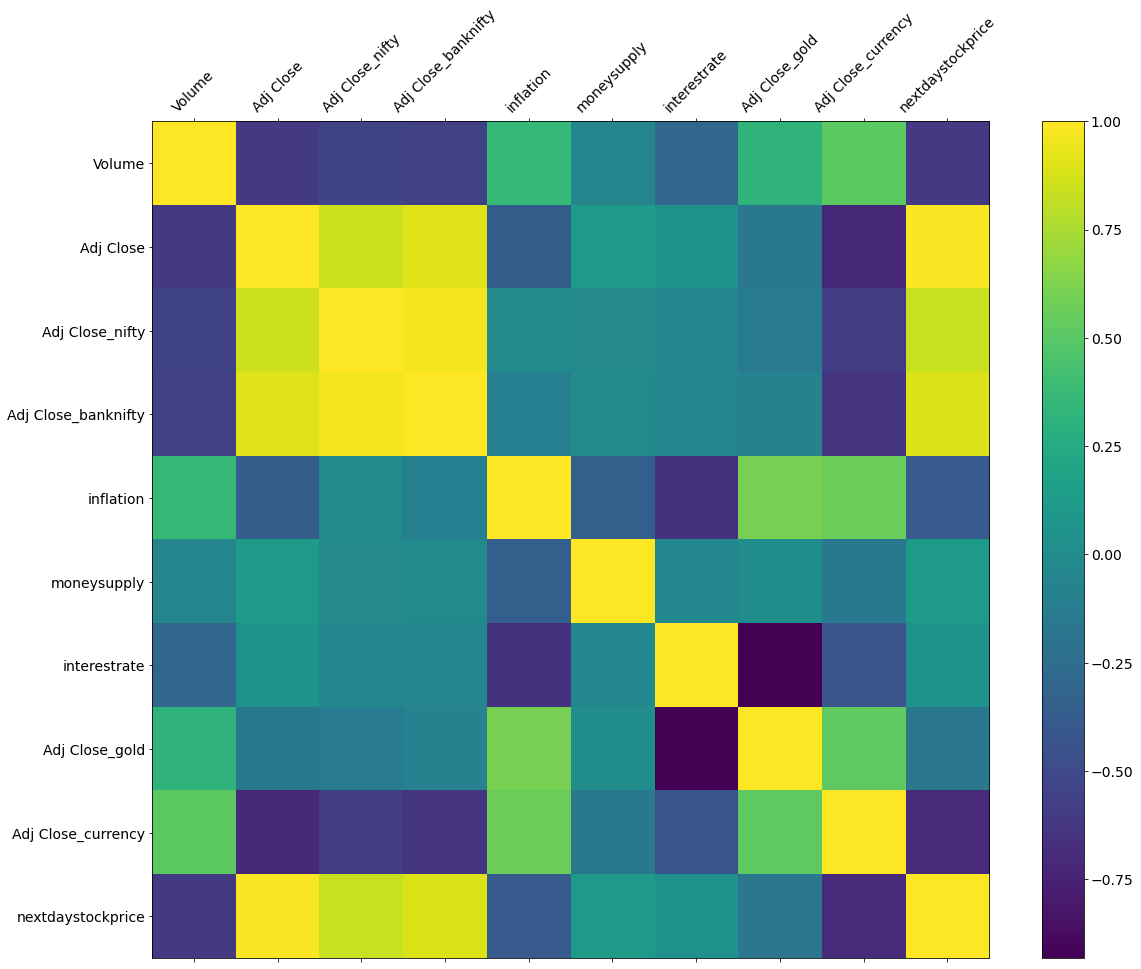

In [ ]:
# Spearman correlation between all features for all rows
f = plt.figure(figsize=(19, 15))
plt.matshow(df_absolute.iloc[:,1:].corr(method='spearman'), fignum=f.number)
plt.xticks(range(df_absolute.iloc[:,1:].shape[1]), df_absolute.iloc[:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_absolute.iloc[:,1:].shape[1]), df_absolute.iloc[:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

### Kendall Correlation

In [ ]:
# Kendall correlation for complete dataset
df_absolute.corr(method='kendall')

Volume  Adj Close  Adj Close_nifty  \
Volume               1.000000  -0.433007        -0.373929   
Adj Close           -0.433007   1.000000         0.660277   
Adj Close_nifty     -0.373929   0.660277         1.000000   
Adj Close_banknifty -0.394927   0.742934         0.846653   
inflation            0.256068  -0.267249        -0.008698   
moneysupply         -0.050733   0.099313        -0.018814   
interestrate        -0.205977   0.004518        -0.099197   
Adj Close_gold       0.208682  -0.094818        -0.048570   
Adj Close_currency   0.359993  -0.531998        -0.410772   
nextdaystockprice   -0.436399   0.900409         0.642990   

                     Adj Close_banknifty  inflation  moneysupply  \
Volume                         -0.394927   0.256068    -0.050733   
Adj Close                       0.742934  -0.267249     0.099313   
Adj Close_nifty                 0.846653  -0.008698    -0.018814   
Adj Close_banknifty             1.000000  -0.076690    -0.002366   
inflation                      -0.076690   1.000000    -0.274344   
moneysupply                    -0.002366  -0.274344     1.000000   
interestrate                   -0.119613  -0.504007    -0.013014   
Adj Close_gold                 -0.018378   0.408462     0.004742   
Adj Close_currency             -0.469431   0.382245    -0.120115   
nextdaystockprice               0.721309  -0.274960     0.101417   

                     interestrate  Adj Close_gold  Adj Close_currency  \
Volume                  -0.205977        0.208682            0.359993   
Adj Close                0.004518       -0.094818           -0.531998   
Adj Close_nifty         -0.099197       -0.048570           -0.410772   
Adj Close_banknifty     -0.119613       -0.018378           -0.469431   
inflation               -0.504007        0.408462            0.382245   
moneysupply             -0.013014        0.004742           -0.120115   
interestrate             1.000000       -0.807095           -0.299735   
Adj Close_gold          -0.807095        1.000000            0.384628   
Adj Close_currency      -0.299735        0.384628            1.000000   
nextdaystockprice        0.008840       -0.098134           -0.526110   

                     nextdaystockprice  
Volume                       -0.436399  
Adj Close                     0.900409  
Adj Close_nifty               0.642990  
Adj Close_banknifty           0.721309  
inflation                    -0.274960  
moneysupply                   0.101417  
interestrate                  0.008840  
Adj Close_gold               -0.098134  
Adj Close_currency           -0.526110  
nextdaystockprice             1.000000

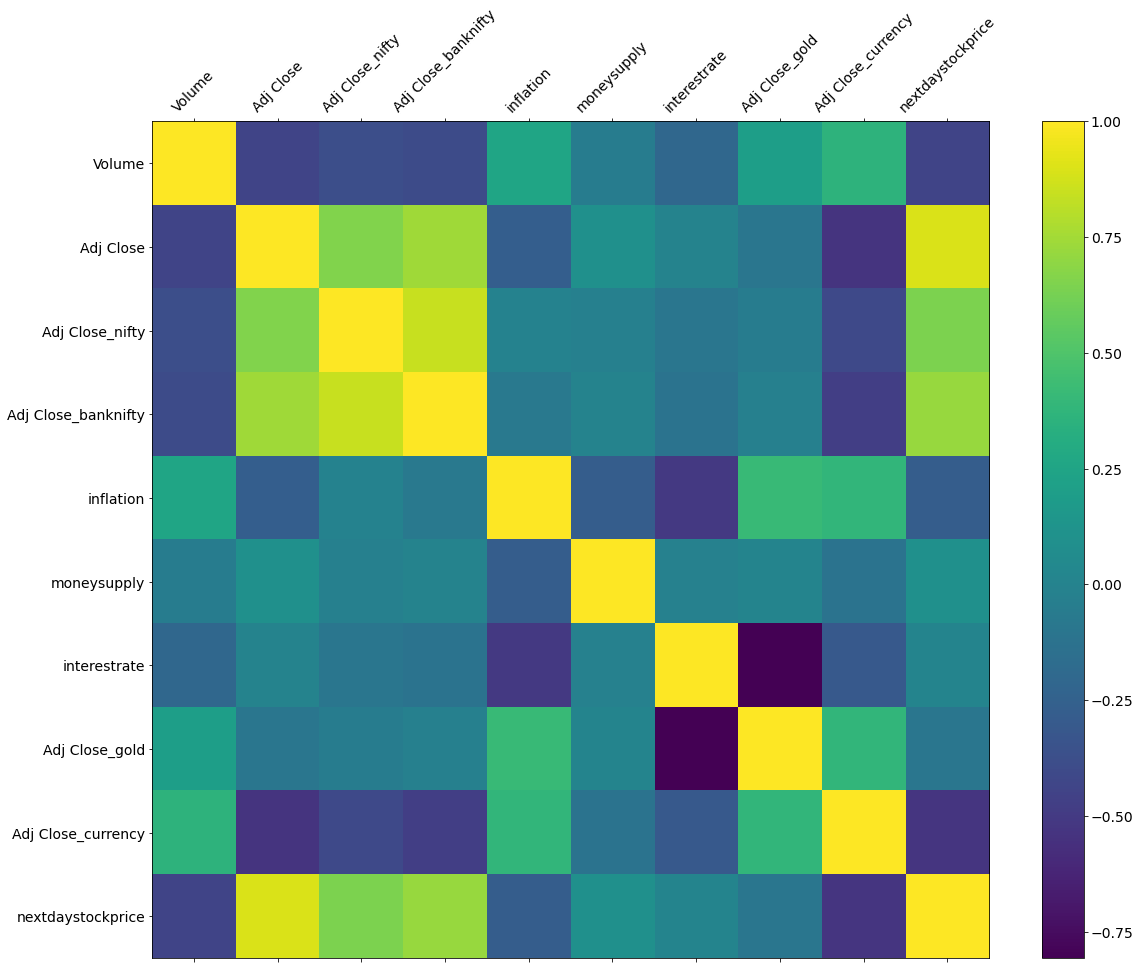

In [ ]:
# Kendall correlation between all features for all rows
f = plt.figure(figsize=(19, 15))
plt.matshow(df_absolute.iloc[:,1:].corr(method='kendall'), fignum=f.number)
plt.xticks(range(df_absolute.iloc[:,1:].shape[1]), df_absolute.iloc[:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_absolute.iloc[:,1:].shape[1]), df_absolute.iloc[:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Correlation among log values

In [ ]:
### log_ratio_stock : log of ratio between current day and previous day
### lognextdaystockinc : log of ratio between coming day and current day. 
### We need to find the correlation between all features and the increase in stock the next day because in actual scenario,
### we will have feature data till the previous day of the day for which we want to predict the stock price


### Pearson Correlation

In [ ]:
# for last 5 rows
df_logval.iloc[-5:,1:].corr(method='pearson')

log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
log_ratio_stock             1.000000         0.874288             0.799924   
log_ratio_nifty             0.874288         1.000000             0.903918   
log_ratio_banknifty         0.799924         0.903918             1.000000   
log_ratio_gold             -0.377897        -0.391525            -0.731661   
log_ratio_currency         -0.597620        -0.560347            -0.820686   
lognextdaystockinc         -0.340932        -0.476325            -0.089223   

                     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
log_ratio_stock           -0.377897           -0.597620           -0.340932  
log_ratio_nifty           -0.391525           -0.560347           -0.476325  
log_ratio_banknifty       -0.731661           -0.820686           -0.089223  
log_ratio_gold             1.000000            0.959611           -0.432693  
log_ratio_currency         0.959611            1.000000           -0.225154  
lognextdaystockinc        -0.432693           -0.225154            1.000000

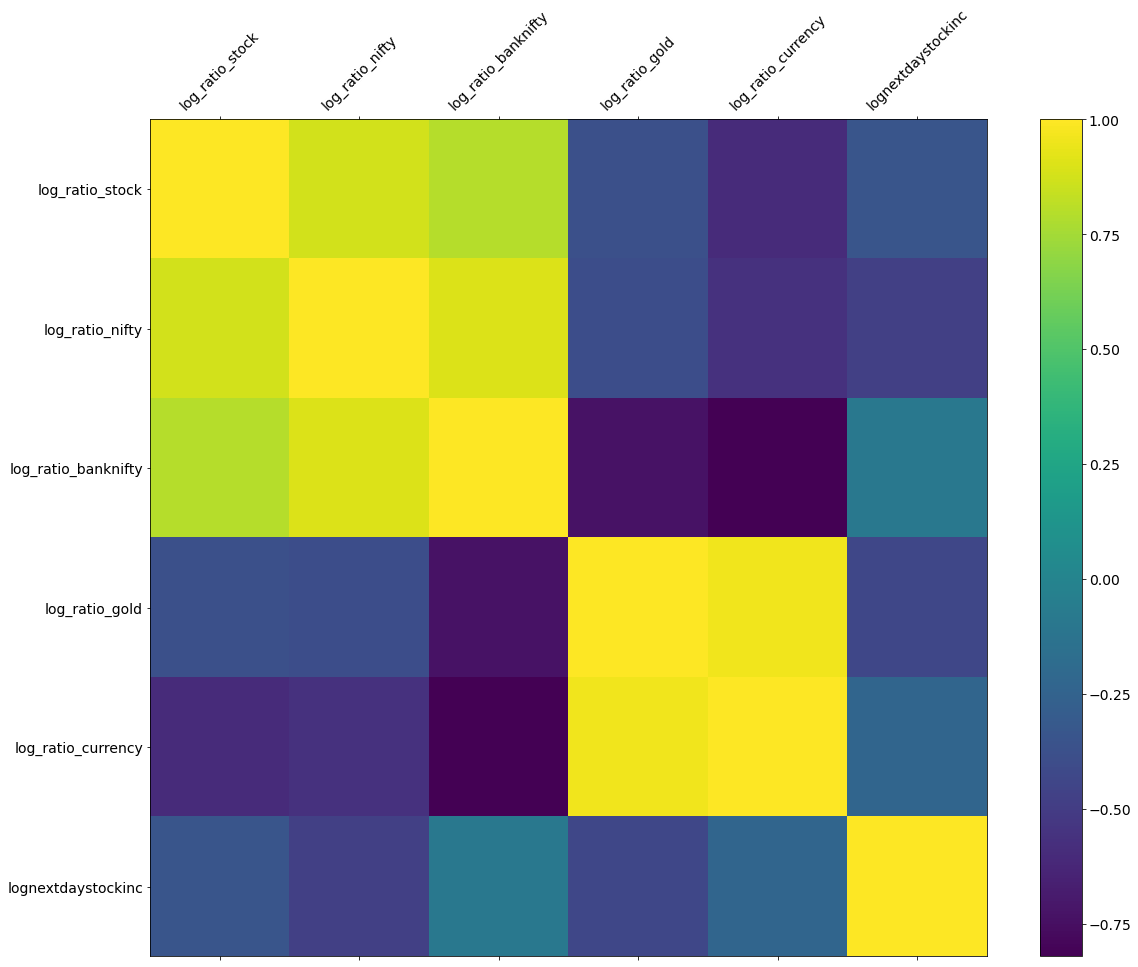

In [ ]:
# Person correlation for last 5 rows of the dataset
f = plt.figure(figsize=(19, 15))
plt.matshow(df_logval.iloc[-5:,1:].corr(), fignum=f.number)
plt.xticks(range(df_logval.iloc[-5:,1:].shape[1]), df_logval.iloc[-5:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_logval.iloc[-5:,1:].shape[1]), df_logval.iloc[-5:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
# correlation for last 5 rows (excluding the last row)
df_logval.iloc[-6:-1,1:].corr(method='pearson')

log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
log_ratio_stock             1.000000         0.938136             0.878978   
log_ratio_nifty             0.938136         1.000000             0.943267   
log_ratio_banknifty         0.878978         0.943267             1.000000   
log_ratio_gold             -0.449394        -0.453185            -0.713723   
log_ratio_currency         -0.610337        -0.571221            -0.774007   
lognextdaystockinc         -0.775786        -0.774670            -0.525443   

                     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
log_ratio_stock           -0.449394           -0.610337           -0.775786  
log_ratio_nifty           -0.453185           -0.571221           -0.774670  
log_ratio_banknifty       -0.713723           -0.774007           -0.525443  
log_ratio_gold             1.000000            0.962840           -0.183950  
log_ratio_currency         0.962840            1.000000            0.007624  
lognextdaystockinc        -0.183950            0.007624            1.000000

In [ ]:
# Pearson correlation among all features for complete dataset
df_logval.corr(method='pearson')

log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
log_ratio_stock             1.000000         0.779134             0.844272   
log_ratio_nifty             0.779134         1.000000             0.929378   
log_ratio_banknifty         0.844272         0.929378             1.000000   
log_ratio_gold             -0.216382        -0.186521            -0.230740   
log_ratio_currency         -0.115312        -0.145946            -0.158272   
lognextdaystockinc          0.005207        -0.034792             0.024696   

                     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
log_ratio_stock           -0.216382           -0.115312            0.005207  
log_ratio_nifty           -0.186521           -0.145946           -0.034792  
log_ratio_banknifty       -0.230740           -0.158272            0.024696  
log_ratio_gold             1.000000            0.150018            0.016505  
log_ratio_currency         0.150018            1.000000           -0.017492  
lognextdaystockinc         0.016505           -0.017492            1.000000

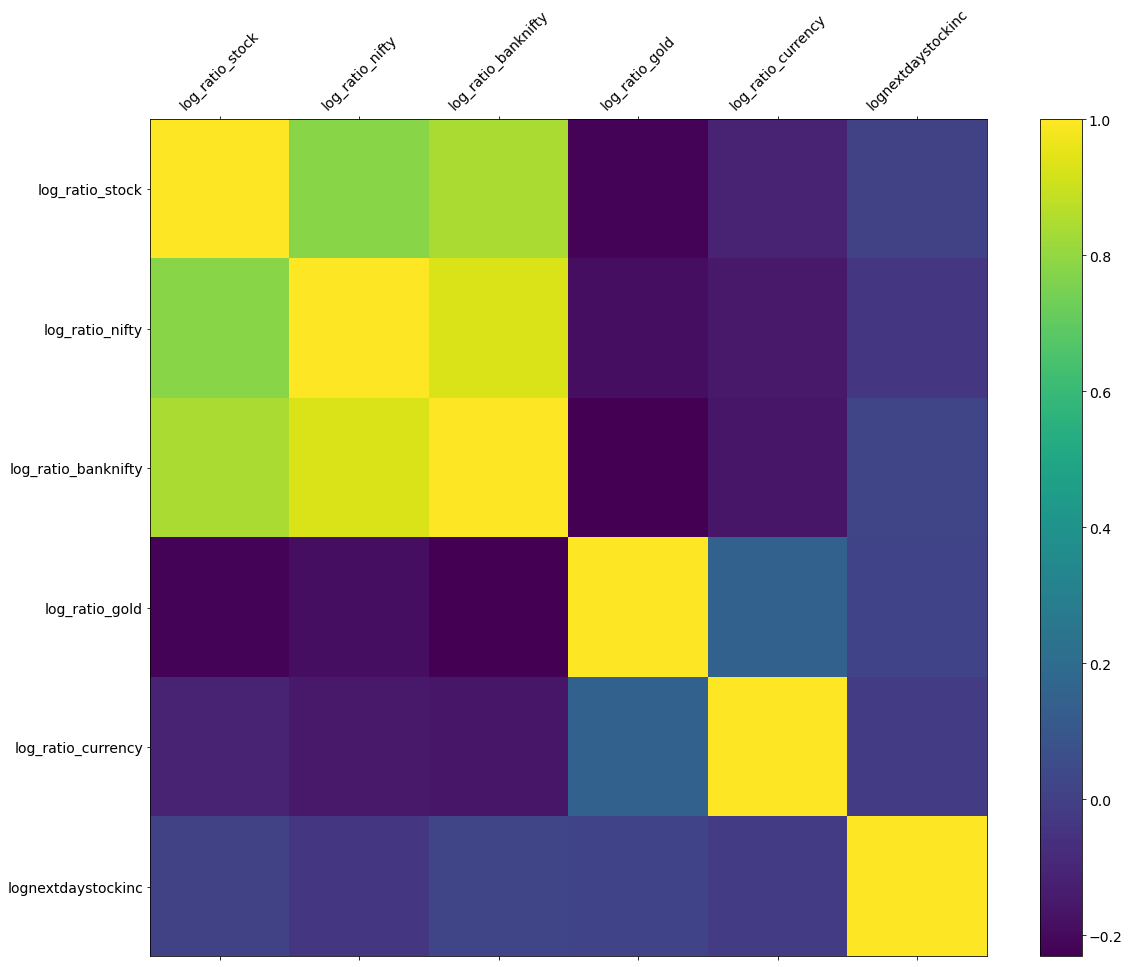

In [ ]:
# Person correlation for all rows of the dataset
f = plt.figure(figsize=(19, 15))
plt.matshow(df_logval.iloc[:,1:].corr(), fignum=f.number)
plt.xticks(range(df_logval.iloc[:,1:].shape[1]), df_logval.iloc[:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_logval.iloc[:,1:].shape[1]), df_logval.iloc[:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

### Spearman Correlation

In [ ]:
# spearman correlation for last 5 rows 
df_logval.iloc[-5:,1:].corr(method='spearman')

log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
log_ratio_stock             1.000000         0.700000             0.700000   
log_ratio_nifty             0.700000         1.000000             1.000000   
log_ratio_banknifty         0.700000         1.000000             1.000000   
log_ratio_gold              0.100000        -0.600000            -0.600000   
log_ratio_currency         -0.153897         0.564288             0.564288   
lognextdaystockinc          0.205196         0.051299             0.051299   

                     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
log_ratio_stock            0.100000           -0.153897            0.205196  
log_ratio_nifty           -0.600000            0.564288            0.051299  
log_ratio_banknifty       -0.600000            0.564288            0.051299  
log_ratio_gold             1.000000           -0.974679            0.153897  
log_ratio_currency        -0.974679            1.000000            0.026316  
lognextdaystockinc         0.153897            0.026316            1.000000

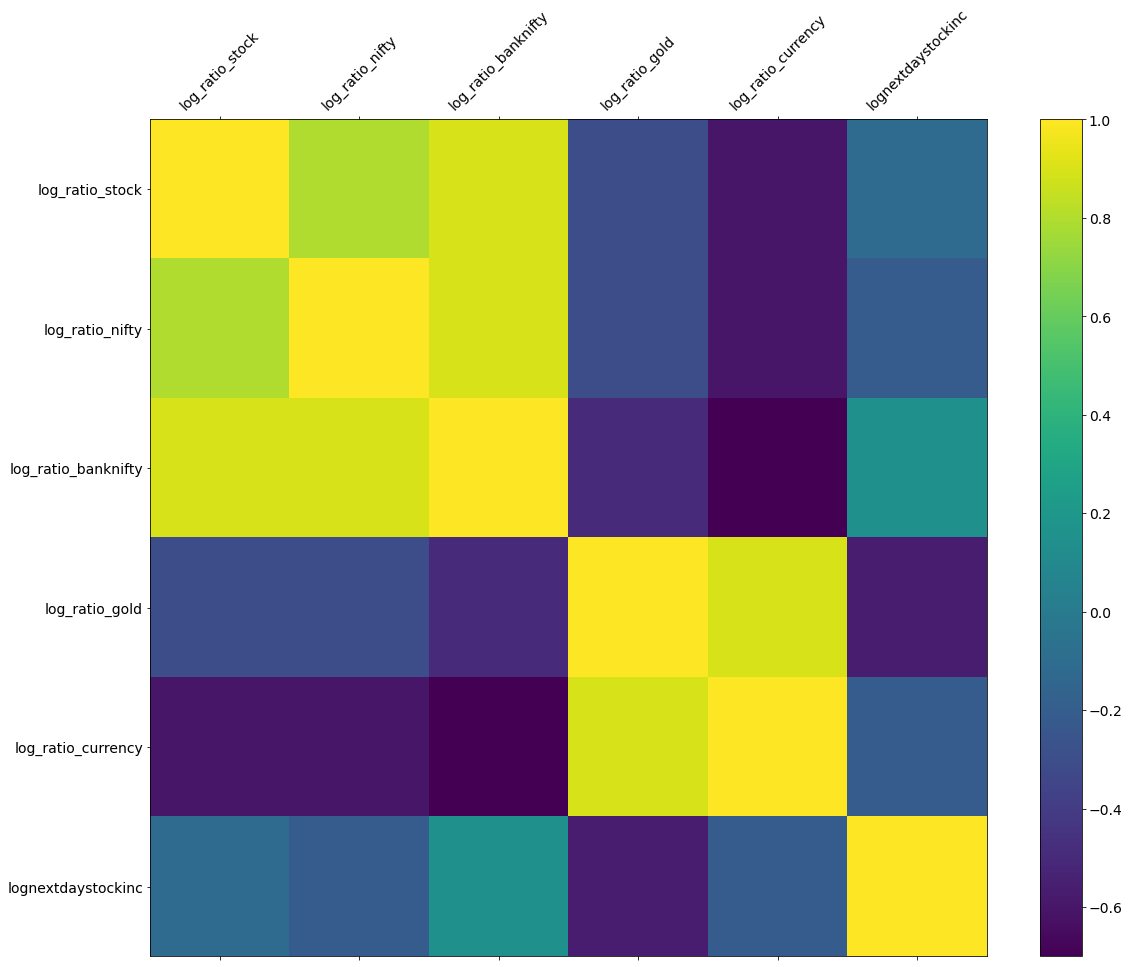

In [ ]:
# Spearman correlation for last 5 rows of the dataset
f = plt.figure(figsize=(19, 15))
plt.matshow(df_logval.iloc[-5:,1:].corr(method='spearman'), fignum=f.number)
plt.xticks(range(df_logval.iloc[-5:,1:].shape[1]), df_logval.iloc[-5:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_logval.iloc[-5:,1:].shape[1]), df_logval.iloc[-5:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
# spearman correlation for complete dataset
df_logval.corr(method='spearman')

log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
log_ratio_stock             1.000000         0.629638             0.713292   
log_ratio_nifty             0.629638         1.000000             0.891232   
log_ratio_banknifty         0.713292         0.891232             1.000000   
log_ratio_gold             -0.194251        -0.237533            -0.240886   
log_ratio_currency         -0.117786        -0.190609            -0.195773   
lognextdaystockinc         -0.018895         0.012598             0.010908   

                     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
log_ratio_stock           -0.194251           -0.117786           -0.018895  
log_ratio_nifty           -0.237533           -0.190609            0.012598  
log_ratio_banknifty       -0.240886           -0.195773            0.010908  
log_ratio_gold             1.000000            0.200517            0.049752  
log_ratio_currency         0.200517            1.000000            0.024048  
lognextdaystockinc         0.049752            0.024048            1.000000

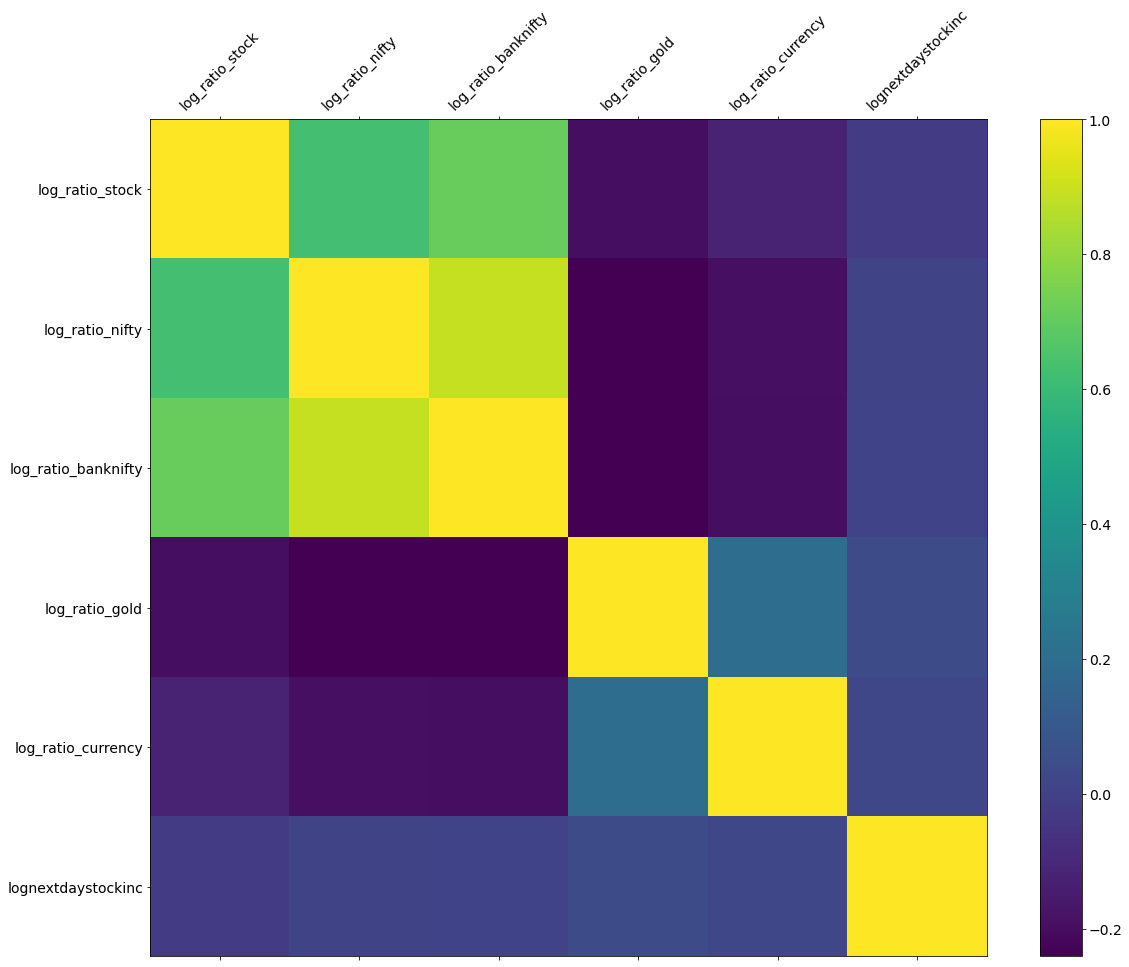

In [ ]:
# Spearman correlation for all rows of the dataset
f = plt.figure(figsize=(19, 15))
plt.matshow(df_logval.iloc[:,1:].corr(method='spearman'), fignum=f.number)
plt.xticks(range(df_logval.iloc[:,1:].shape[1]), df_logval.iloc[:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_logval.iloc[:,1:].shape[1]), df_logval.iloc[:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Kendall Correlation

In [ ]:
# Kendall correlation for last 5 rows of the dataset
df_logval.iloc[-5:,1:].corr(method='kendall')

log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
log_ratio_stock             1.000000         0.600000             0.800000   
log_ratio_nifty             0.600000         1.000000             0.800000   
log_ratio_banknifty         0.800000         0.800000             1.000000   
log_ratio_gold             -0.200000        -0.200000            -0.400000   
log_ratio_currency         -0.400000        -0.400000            -0.600000   
lognextdaystockinc         -0.105409        -0.105409             0.105409   

                     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
log_ratio_stock           -0.200000           -0.400000           -0.105409  
log_ratio_nifty           -0.200000           -0.400000           -0.105409  
log_ratio_banknifty       -0.400000           -0.600000            0.105409  
log_ratio_gold             1.000000            0.800000           -0.316228  
log_ratio_currency         0.800000            1.000000           -0.105409  
lognextdaystockinc        -0.316228           -0.105409            1.000000

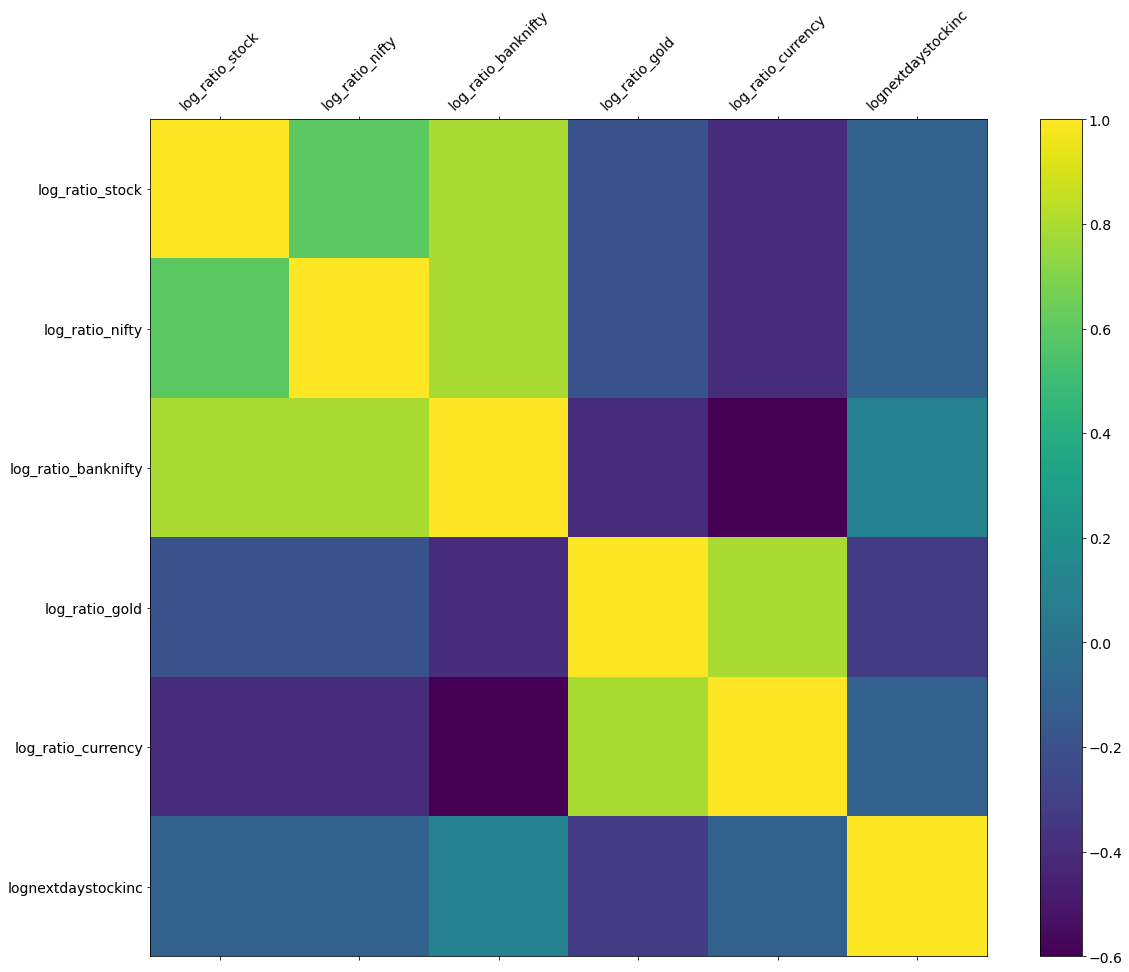

In [ ]:
# Kendall correlation for last 5 rows of the dataset
f = plt.figure(figsize=(19, 15))
plt.matshow(df_logval.iloc[-5:,1:].corr(method='kendall'), fignum=f.number)
plt.xticks(range(df_logval.iloc[-5:,1:].shape[1]), df_logval.iloc[-5:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_logval.iloc[-5:,1:].shape[1]), df_logval.iloc[-5:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [ ]:
# Kendall correlation for complete dataset
df_logval.corr(method='kendall')

log_ratio_stock  log_ratio_nifty  log_ratio_banknifty  \
log_ratio_stock             1.000000         0.463892             0.536231   
log_ratio_nifty             0.463892         1.000000             0.723210   
log_ratio_banknifty         0.536231         0.723210             1.000000   
log_ratio_gold             -0.133699        -0.169009            -0.172140   
log_ratio_currency         -0.081431        -0.131299            -0.136972   
lognextdaystockinc         -0.016741         0.009479             0.007026   

                     log_ratio_gold  log_ratio_currency  lognextdaystockinc  
log_ratio_stock           -0.133699           -0.081431           -0.016741  
log_ratio_nifty           -0.169009           -0.131299            0.009479  
log_ratio_banknifty       -0.172140           -0.136972            0.007026  
log_ratio_gold             1.000000            0.136137            0.033981  
log_ratio_currency         0.136137            1.000000            0.016260  
lognextdaystockinc         0.033981            0.016260            1.000000

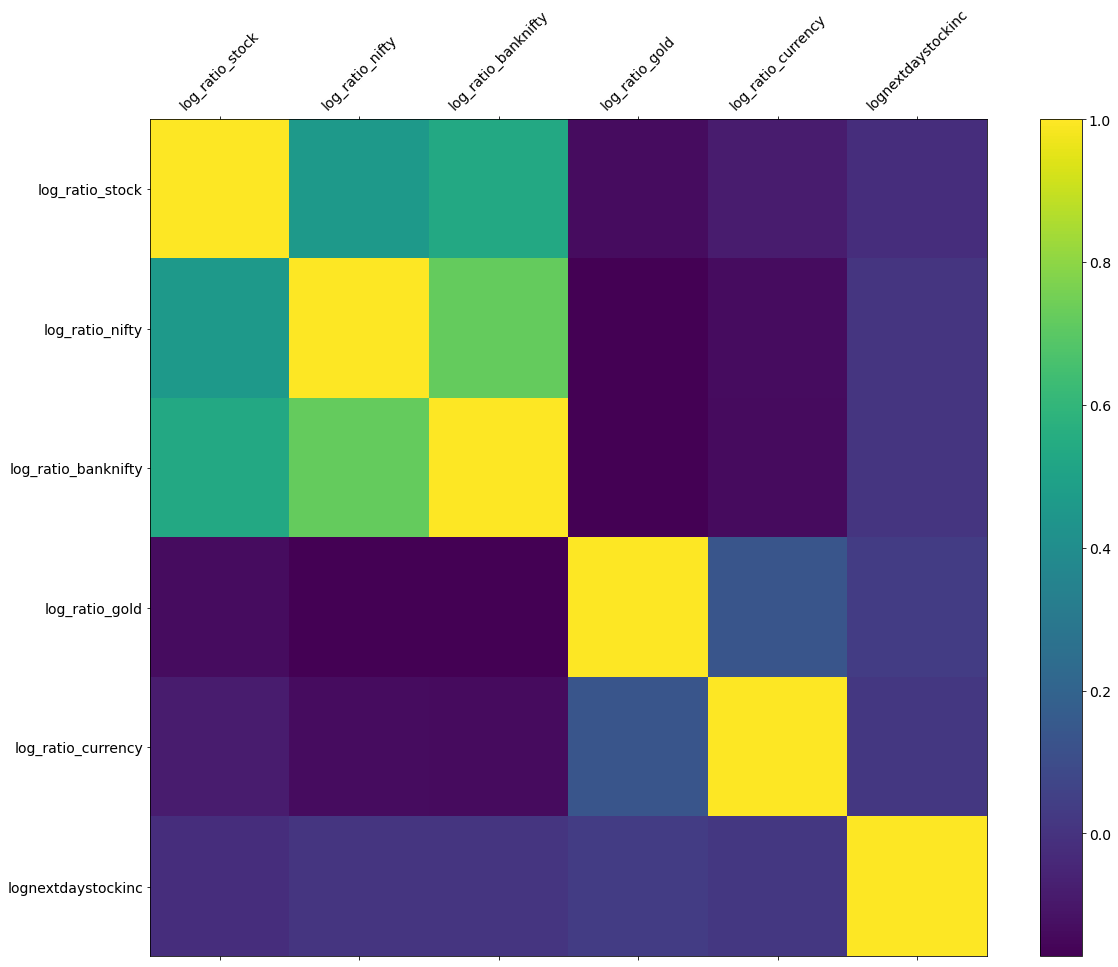

In [ ]:
# Kendall correlation for all rows of the dataset
f = plt.figure(figsize=(19, 15))
plt.matshow(df_logval.iloc[:,1:].corr(method='kendall'), fignum=f.number)
plt.xticks(range(df_logval.iloc[:,1:].shape[1]), df_logval.iloc[:,1:].columns, fontsize=14, rotation=45)
plt.yticks(range(df_logval.iloc[:,1:].shape[1]), df_logval.iloc[:,1:].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)